In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

## Load test image

In [15]:
img = Image.open('./test_img.jpg')

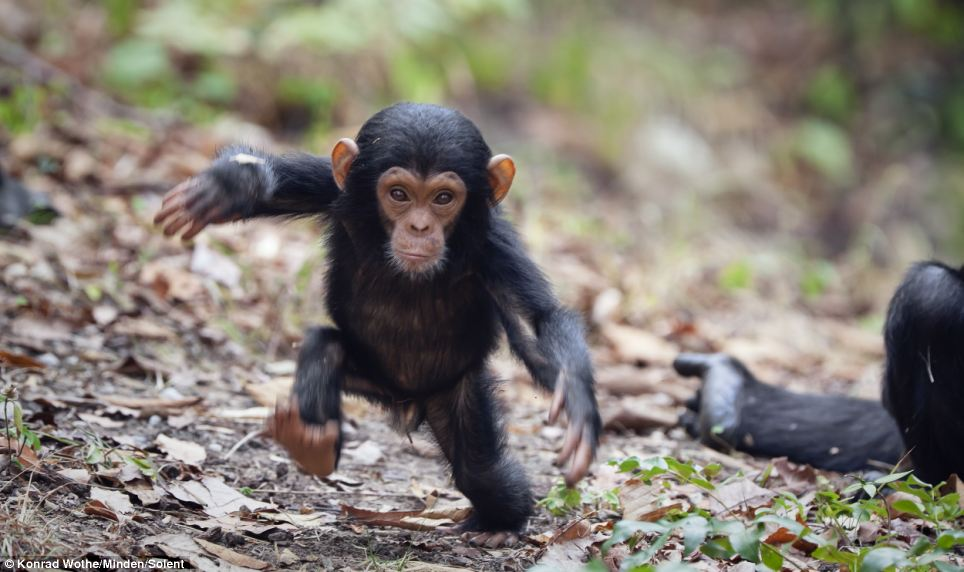

In [23]:
img

## Understand convolution operation

In [59]:
kernel = np.random.random((5, 5)) / 5
# size = 3x3
stride = 1
padding = 1

kernel = np.stack([kernel, kernel, kernel], axis=0)

After these parameters are defined this is all we need for this basic image -> image case where 3 chanels use the same kernel

## Kernel params demo

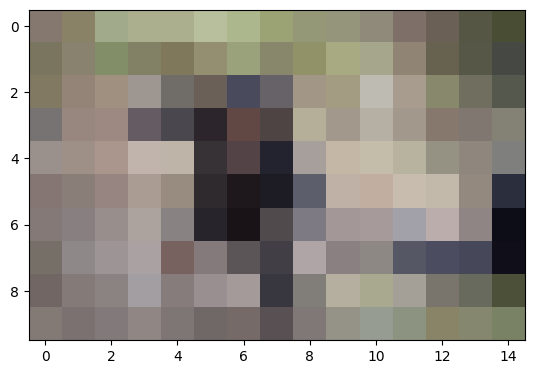

In [84]:
test_kernel_img = img.resize((15, 10))

plt.imshow(test_kernel_img)

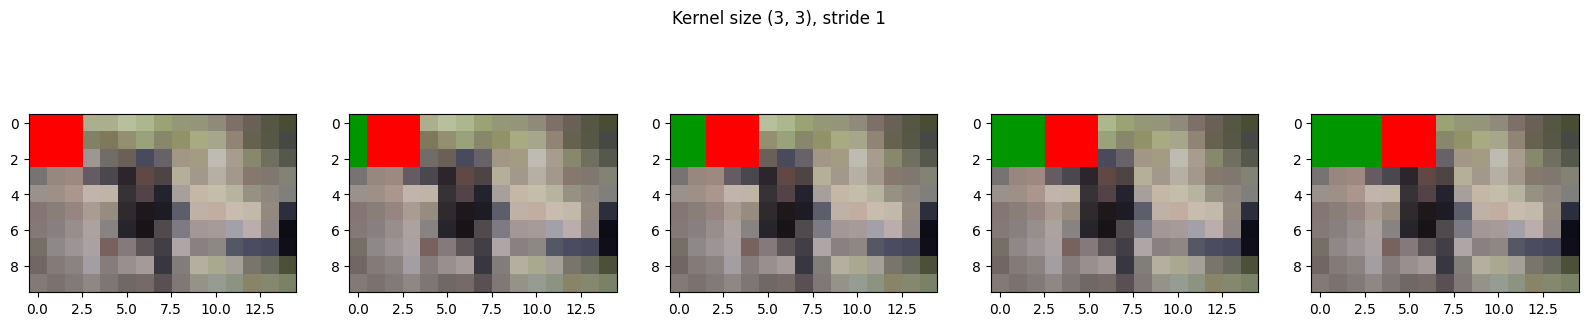

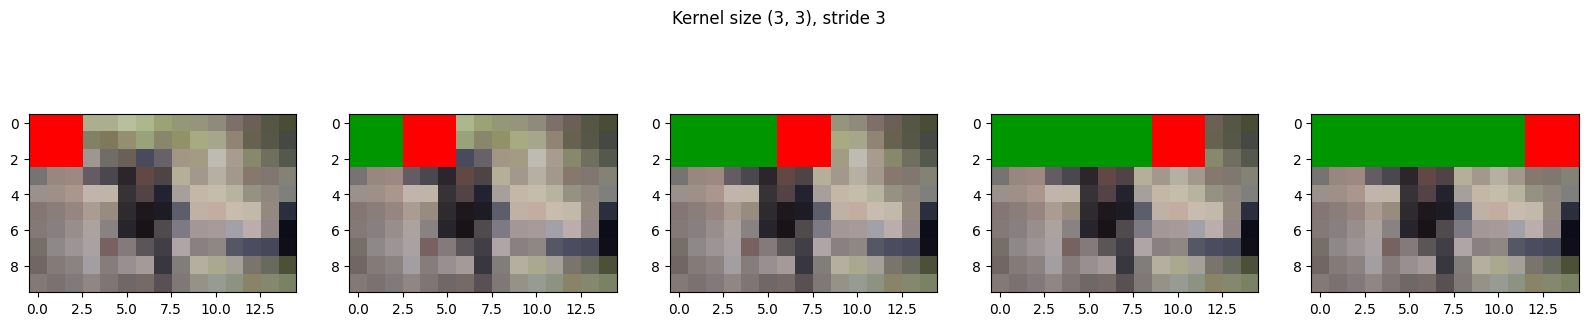

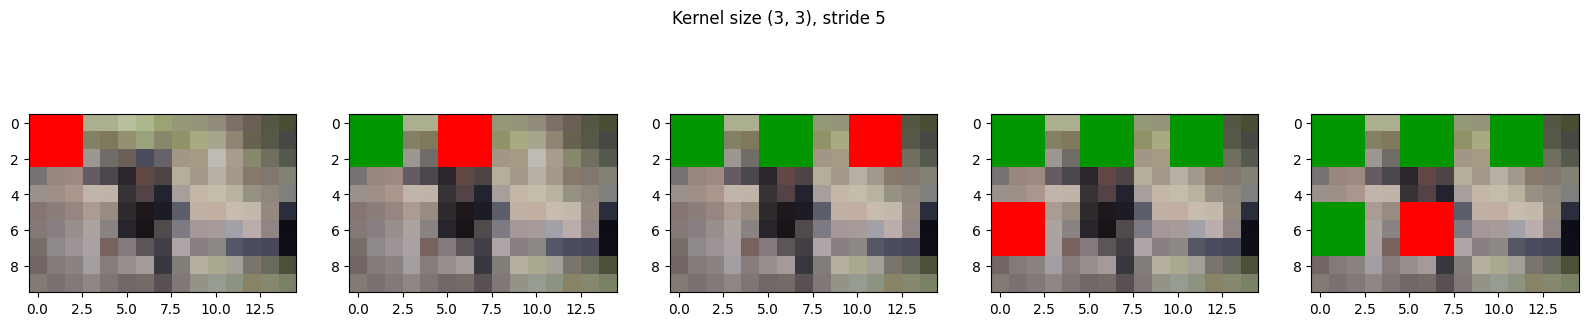

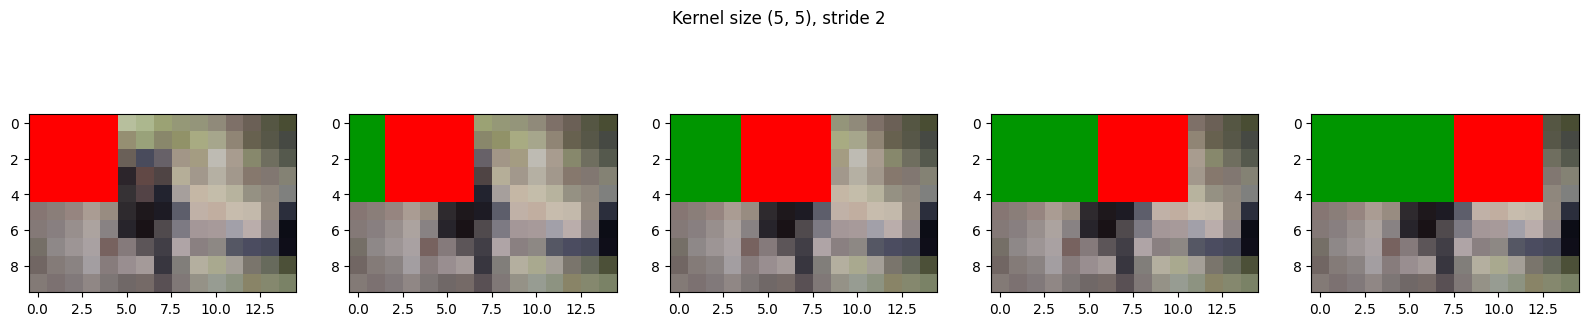

In [91]:
def show_kernel_move(kernel_size, stride):
    img_array = np.array(test_kernel_img)
    img_array = np.transpose(img_array, (2, 0, 1))

    _, height, width = img_array.shape

    patch_height, patch_width = kernel_size

    height_iter = range(0, height - patch_height + 1, stride)

    width_iter  = range(0, width - patch_width + 1, stride)

    counter = 0

    fig, ax = plt.subplots(1,5, figsize=(20, 4))
    fig.suptitle(f"Kernel size {kernel_size}, stride {stride}")
    for h in height_iter:
        for w in width_iter:
            copy_img = img_array.copy()

            patch = np.zeros((copy_img.shape[0], patch_height, patch_width), dtype=copy_img.dtype)

            patch[0, :, :] = 255

            copy_img[:, h:h + patch_height, w:w + patch_width] = patch

            axis = ax[counter]

            axis.imshow(np.transpose(copy_img, (1, 2, 0)))

            patch_visited = np.zeros((copy_img.shape[0], patch_height, patch_width), dtype=copy_img.dtype)

            patch_visited[1, :, :] = 150

            img_array[:, h:h + patch_height, w:w + patch_width] = patch_visited

            counter += 1
            if counter == 5:
                plt.show()
                return

configurations = [
    ((3,3), 1),
    ((3,3), 3),
    ((3,3), 5),
    ((5,5), 2)
]

for configuration in configurations:
    show_kernel_move(configuration[0], configuration[1])


In [ ]:
class ConvNet:
    def __init__(self):


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)